# Init Code

In [1]:
import Waven.WaveletGenerator as wg
import Waven.Analysis_Utils as au
import Waven.LoadPinkNoise as lpn
import numpy as np
import gc
import os
import torch

results = None

# Run Zebra Analysis

In [ ]:
# List of default parameters for the Gabor Library
gabor_param={
    "N_thetas":"8",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    "Phases": "[0, 90]",
    "NX": "135",
    "NY": "54",
    "Save Path":"/home/leonk/waven-working-/temp/gabors_library.npy"
}

# List of default parameters
param_defaults = {
    "Path Directory": "",
    "Dirs": "/home/leonk/waven-working-/temp/LE_ROS-2210_2025-11-28_scan9FXEU7TJ_sess9FXEU7TJ",
    "Experiment Info": ["0", "1", "2"],
    "Number of Planes": "1",
    "Block End": "0",
    "screen_x":"800",
    "screen_y":"600",
    "NX": "135",
    "NY": "54",
    "Resolution":"1.2",
    "Sigmas": "[2, 3, 4, 5, 6, 8]",
    "Frequencies": "[0.015, 0.04, 0.07, 0.1]",
    "Visual Coverage":"[-135, 45, 34, -34]",
    "Analysis Coverage": "[-135, 0, 34, -34]",
    "Number of Frames": "54001",  # stimulus frames in each trial
    "Number of Trials to Keep": "1",
    "Movie Path": "/home/leonk/waven-working-/temp/fullscreen_zebra.mp4",
    "Library Path": "/home/leonk/waven-working-/temp/gabors_library.npy",
    "Spks Path": "None"
}


In [ ]:
# Non-GUI analysis workflow
import matplotlib.pyplot as plt
from pathlib import Path

def run_analysis(param_defaults, gabor_param):
    """
    Run analysis without GUI - suitable for Jupyter notebooks and headless environments
    """
    
    # Extract parameters
    path_directory = param_defaults["Path Directory"]
    dirs = [param_defaults["Dirs"]]
    exp_info = param_defaults["Experiment Info"]
    sigmas = np.array(eval(param_defaults["Sigmas"]))
    visual_coverage = eval(param_defaults["Visual Coverage"])
    analysis_coverage = eval(param_defaults["Analysis Coverage"])
    n_planes = int(param_defaults["Number of Planes"])
    block_end = int(param_defaults["Block End"])
    screen_x = int(param_defaults["screen_x"])
    screen_y = int(param_defaults["screen_y"])
    nx = int(param_defaults["NX"])
    ny = int(param_defaults["NY"])
    ns = len(sigmas)
    resolution = float(param_defaults["Resolution"])
    spks_path = param_defaults["Spks Path"]
    nb_frames = int(param_defaults["Number of Frames"])
    n_trial2keep = int(param_defaults["Number of Trials to Keep"])
    movpath = param_defaults["Movie Path"]
    lib_path = param_defaults["Library Path"]
    n_theta = int(gabor_param["N_thetas"])
    
    screen_ratio = abs(visual_coverage[0] - visual_coverage[1]) / nx
    xM, xm, yM, ym = analysis_coverage
    
    print(f"Visual coverage: {visual_coverage}, Sigmas: {sigmas}, NS: {ns}")
    print(f"Experiment info: {exp_info}")
    print(f"Directories: {dirs}")
    
    # Build paths
    pathdata = dirs[0] + '/' + exp_info[0] + '/' + exp_info[1] + '/' + str(exp_info[2])
    pathsuite2p = pathdata + '/suite2p'
    
    deg_per_pix = abs(xM - xm) / nx
    sigmas_deg = np.trunc(2 * deg_per_pix * sigmas * 100) / 100
    
    print(f"Data path: {pathdata}")
    print(f"Suite2p path: {pathsuite2p}")
    
    # Load spike data
    if spks_path == 'None':
        print('Aligning data...')
        spks, spks_n, neuron_pos = lpn.loadSPKMesoscope(exp_info, dirs, pathsuite2p, block_end, n_planes, nb_frames,
                                                        threshold=1.25, last=True, method='frame2ttl')
        neuron_pos = lpn.correctNeuronPos(neuron_pos, resolution)
        neuron_pos[:, 1] = abs(neuron_pos[:, 1] - np.max(neuron_pos[:, 1]))
    else:
        print(f'Loading spks file from {spks_path}')
        try:
            spks = np.load(spks_path)
            parent_dir = os.path.dirname(spks_path)
            neuron_pos = np.load(os.path.join(parent_dir, 'pos.npy'))
        except Exception as e:
            print(f"Error loading file: {e}")
            return None
    
    print(f"Spike data shape: {spks.shape}")
    print(f"Neuron positions shape: {neuron_pos.shape}")
    
    # Compute response reliability and skewness
    print("Computing response reliability and skewness...")
    
    # Check if we have multiple trials for reliability calculation
    n_neurons = spks.shape[0]
    if n_trial2keep > 1:
        # Multiple trials - compute cross-trial reliability
        respcorr = au.repetability_trial3(spks, neuron_pos, plotting=False)
    else:
        # Single trial - skip reliability, set to default values
        print("Single trial detected - skipping cross-trial reliability calculation")
        respcorr = np.ones(n_neurons)  # No filtering based on reliability for single trial
    
    skewness = au.compute_skewness_neurons(spks, plotting=False)
    skewness = np.array(skewness)
    
    # Create filter mask
    if n_trial2keep > 1:
        filter_mask = np.logical_and(respcorr >= 0.2, skewness <= 20)
    else:
        # For single trial, only filter by skewness
        filter_mask = skewness <= 20
    
    print(f"Neurons passing filter: {np.sum(filter_mask)}/{n_neurons}")
    
    # Plot neuron positions
    fig1, ax1 = plt.subplots(figsize=(8, 8))
    ax1.scatter(neuron_pos[:, 0], neuron_pos[:, 1], c='k', alpha=0.5, s=30)
    ax1.set_xlabel('X position (um)')
    ax1.set_ylabel('Y position (um)')
    ax1.set_title("Neuron Positions")
    plt.tight_layout()
    plt.show()
    
    # Load wavelets
    parent_dir = os.path.dirname(movpath)
    print(f"Loading wavelets from {parent_dir}...")
    
    # First try: load pre-computed downsampled wavelets
    try:
        wavelets_downsampled = np.load(os.path.join(parent_dir, 'dwt_downsampled_videodata.npy'))
        w_r_downsampled = wavelets_downsampled[0]
        w_i_downsampled = wavelets_downsampled[1]
        w_c_downsampled = wavelets_downsampled[2]
        del wavelets_downsampled
        gc.collect()
        print("Loaded downsampled wavelets")
    except Exception as e:
        print(f"Downsampled wavelets not found: {e}")
        
        # Second try: load coarse wavelets
        try:
            print("Attempting to load coarse wavelets...")
            w_r_downsampled, w_i_downsampled, w_c_downsampled = lpn.coarseWavelet(parent_dir, False, nx, ny, 27, 11,
                                                                                  n_theta, ns)
            print("Loaded coarse wavelets")
        except Exception as e:
            print(f"Error loading wavelets: {e}")
            
            # Third try: Check if downsampled video exists and generate wavelets
            downsampled_video_path = movpath[:-4] + '_downsampled.npy'
            if os.path.exists(downsampled_video_path):
                print(f"Found downsampled video at {downsampled_video_path}")
                print("Generating wavelet decomposition from downsampled video...")
                try:
                    videodata = np.load(downsampled_video_path)
                    print(f"Video data shape: {videodata.shape}")
                    
                    wg.waveletDecomposition(videodata, 0, sigmas, parent_dir, library_path=lib_path)
                    wg.waveletDecomposition(videodata, 1, sigmas, parent_dir, library_path=lib_path)
                    
                    w_r_downsampled, w_i_downsampled, w_c_downsampled = lpn.coarseWavelet(parent_dir, False, nx, ny, 27, 11,
                                                                                          n_theta, ns)
                    print("Completed wavelet decomposition from existing downsampled video")
                except Exception as e2:
                    print(f"Error in wavelet decomposition: {e2}")
                    return None
            else:
                # Fourth try: Full pipeline - downsample video then decompose
                print("Attempting full video processing pipeline...")
                try:
                    if (visual_coverage != analysis_coverage):
                        visual_coverage_arr = np.array(visual_coverage)
                        analysis_coverage_arr = np.array(analysis_coverage)
                        ratio_x = 1 - ((visual_coverage_arr[0] - visual_coverage_arr[1]) - (
                                analysis_coverage_arr[0] - analysis_coverage_arr[1])) / (
                                          visual_coverage_arr[0] - visual_coverage_arr[1])
                        ratio_y = 1 - ((visual_coverage_arr[2] - visual_coverage_arr[3]) - (
                                analysis_coverage_arr[2] - analysis_coverage_arr[3])) / (
                                          visual_coverage_arr[2] - visual_coverage_arr[3])
                    else:
                        ratio_x = 1
                        ratio_y = 1
                    
                    print(f"Downsampling video: {movpath}")
                    wg.downsample_video_binary(movpath, visual_coverage, analysis_coverage, shape=(ny, nx), chunk_size=1000,
                                            ratios=(ratio_x, ratio_y))
                    videodata = np.load(movpath[:-4] + '_downsampled.npy')
                    print(f"Downsampled video shape: {videodata.shape}")
                    
                    wg.waveletDecomposition(videodata, 0, sigmas, parent_dir, library_path=lib_path)
                    wg.waveletDecomposition(videodata, 1, sigmas, parent_dir, library_path=lib_path)
                    
                    w_r_downsampled, w_i_downsampled, w_c_downsampled = lpn.coarseWavelet(parent_dir, False, nx, ny, 27, 11,
                                                                                          n_theta, ns)
                    print("Completed full wavelet decomposition")
                except Exception as e3:
                    print(f"Error in full pipeline: {e3}")
                    return None
    
    # Compute receptive fields using Pearson correlation
    print("Computing receptive fields...")
    print(f"w_c_downsampled shape: {w_c_downsampled.shape}")
    print(f"Expected: (27300, 27, 11, {n_theta}, {ns})")
    
    # Use the actual number of frames we have
    n_frames_to_use = min(w_c_downsampled.shape[0], spks.shape[1])
    print(f"Using {n_frames_to_use} frames for RF calculation")
    
    rfs_gabor = au.PearsonCorrelationPinkNoise(w_c_downsampled[:n_frames_to_use].reshape(n_frames_to_use, -1), 
                                                np.mean(spks[:, :n_frames_to_use], axis=0),
                                                neuron_pos, 27, 11, ns, analysis_coverage, 
                                                screen_ratio, sigmas_deg, plotting=True)
    
    # Plot retinotopy maps
    fig2, ax2 = plt.subplots(2, 2, figsize=(14, 12))
    maxes1 = rfs_gabor[2]
    plt.rcParams['axes.facecolor'] = 'none'
    
    m = ax2[0, 0].scatter(neuron_pos[:, 0], neuron_pos[:, 1], s=10, c=maxes1[0], cmap='jet', alpha=filter_mask)
    fig2.colorbar(m, ax=ax2[0, 0])
    ax2[0, 0].set_title('Azimuth Preference (deg)')
    ax2[0, 0].set_xlabel('X (um)')
    ax2[0, 0].set_ylabel('Y (um)')
    
    m = ax2[0, 1].scatter(neuron_pos[:, 0], neuron_pos[:, 1], s=10, c=maxes1[1], cmap='jet_r', alpha=filter_mask)
    fig2.colorbar(m, ax=ax2[0, 1])
    ax2[0, 1].set_title('Elevation Preference (deg)')
    ax2[0, 1].set_xlabel('X (um)')
    ax2[0, 1].set_ylabel('Y (um)')
    
    m = ax2[1, 0].scatter(neuron_pos[:, 0], neuron_pos[:, 1], s=10, c=maxes1[2], cmap='hsv', alpha=filter_mask)
    fig2.colorbar(m, ax=ax2[1, 0])
    ax2[1, 0].set_title('Orientation Preference (deg)')
    ax2[1, 0].set_xlabel('X (um)')
    ax2[1, 0].set_ylabel('Y (um)')
    
    m = ax2[1, 1].scatter(neuron_pos[:, 0], neuron_pos[:, 1], s=10, c=maxes1[3], cmap='coolwarm', alpha=filter_mask)
    fig2.colorbar(m, ax=ax2[1, 1])
    ax2[1, 1].set_title('Preferred Size (deg)')
    ax2[1, 1].set_xlabel('X (um)')
    ax2[1, 1].set_ylabel('Y (um)')
    
    plt.tight_layout()
    plt.show()
    
    # Save results
    print("Saving results...")
    np.save(os.path.join(parent_dir, 'correlation_matrix.npy'), rfs_gabor[0])
    np.save(os.path.join(parent_dir, 'maxes_indices.npy'), rfs_gabor[1])
    np.save(os.path.join(parent_dir, 'maxes_corrected.npy'), rfs_gabor[2])
    
    print("Analysis complete!")
    return {
        'spks': spks,
        'neuron_pos': neuron_pos,
        'rfs_gabor': rfs_gabor,
        'filter_mask': filter_mask,
        'respcorr': respcorr,
        'skewness': skewness
    }

# Run the analysis
print("Starting analysis pipeline...")
results = run_analysis(param_defaults, gabor_param)


In [ ]:
# save results
if results is not None:
    print("Results keys:", results.keys())
    np.save('/home/leonk/waven-working-/temp/analysis_results.npy', results)

# Check and visualize results

In [2]:
#load results
if results is None:
    results = np.load('/home/leonk/waven-working-/temp/analysis_results.npy', allow_pickle=True).item()
#show result keys
print("Results keys:", results.keys())

Results keys: dict_keys(['spks', 'neuron_pos', 'rfs_gabor', 'filter_mask', 'respcorr', 'skewness'])


Plot neuron positions

x position range: 3.6 to 184.8
y position range: 0.0 to 1596.0
Number of neurons: 500


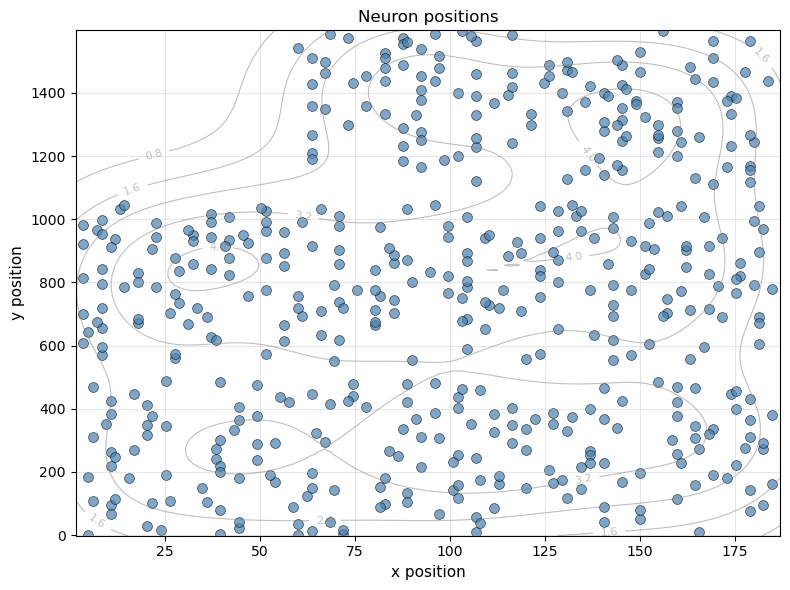

In [6]:
%matplotlib inline
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

xos = results["neuron_pos"][:,0]  # x position
yos = results["neuron_pos"][:,1]  # y position

print(f"x position range: {xos.min():.1f} to {xos.max():.1f}")
print(f"y position range: {yos.min():.1f} to {yos.max():.1f}")
print(f"Number of neurons: {len(xos)}")

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate density for contours
xy = np.vstack([xos, yos])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(xos) - 2, max(xos) + 2, 100)
y_grid = np.linspace(min(yos) - 2, max(yos) + 2, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

# Plot density contours
contours = ax.contour(X, Y, Z, levels=5, colors='gray', alpha=0.5, linewidths=0.8)
ax.clabel(contours, inline=True, fontsize=8)

# Overlay scatter plot
ax.scatter(xos, yos, color='steelblue', s=50, alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('x position', fontsize=11)
ax.set_ylabel('y position', fontsize=11)
ax.set_title('Neuron positions', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Plot RF positions

Looking at the code, results["rfs_gabor"] contains the output from PearsonCorrelationPinkNoise, which computes receptive fields. Based on how it's used in the plotting section, rfs_gabor is a tuple/list with 3 elements:

rfs_gabor[0] - Correlation matrix

Full correlation values between each neuron and each Gabor filter feature
Shape: (n_neurons, n_gabor_features) where n_gabor_features = 27 × 11 × n_theta × ns
These are the raw Pearson correlation coefficients
rfs_gabor[1] - Maximum indices

For each neuron, the indices of the Gabor features that gave the maximum correlation
Shape: (n_neurons, 4) where the 4 dimensions correspond to:
Azimuth position index (0-26)
Elevation position index (0-10)
Orientation index (0-7)
Size/scale index (0-5)
rfs_gabor[2] - Maxes corrected

The actual preference values converted to meaningful units:
maxes1[0]: Azimuth preference in degrees
maxes1[1]: Elevation preference in degrees
maxes1[2]: Orientation preference in degrees (0-180°)
maxes1[3]: Preferred size in degrees (sigma of Gabor)
Shape: (4, n_neurons)
These are the values displayed in the retinotopy maps
So in summary:

[0] = all correlations (for detailed analysis)
[1] = best-matching feature indices (for reconstruction)
[2] = preferred stimulus properties in degrees (for visualization)

Azimuth range: -135.0 to -5.0 degrees
Elevation range: -27.8 to 34.0 degrees
Number of neurons: 500


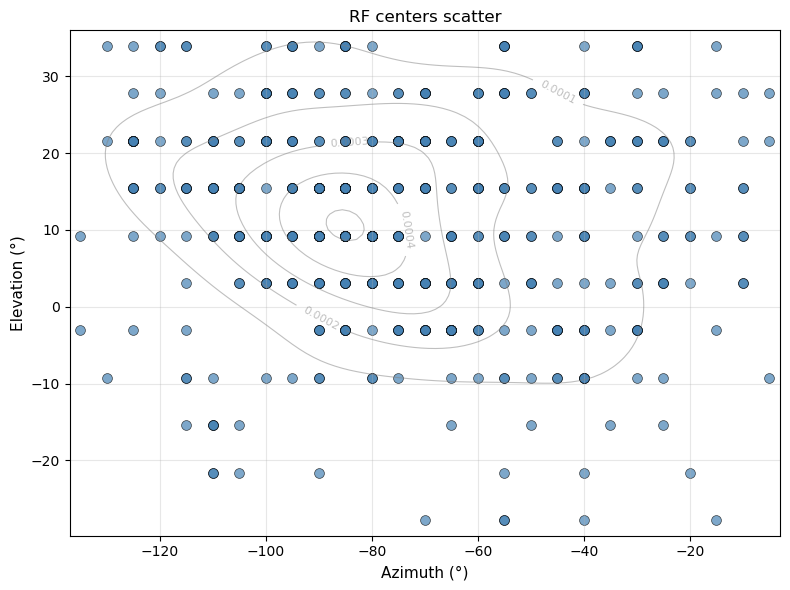

In [7]:
%matplotlib inline
from scipy.stats import gaussian_kde
import matplotlib.pyplot as plt

xos = results["rfs_gabor"][2][0]  # Azimuth preference in degrees
yos = results["rfs_gabor"][2][1]  # Elevation preference in degrees

print(f"Azimuth range: {xos.min():.1f} to {xos.max():.1f} degrees")
print(f"Elevation range: {yos.min():.1f} to {yos.max():.1f} degrees")
print(f"Number of neurons: {len(xos)}")

# Create figure
fig, ax = plt.subplots(figsize=(8, 6))

# Calculate density for contours
xy = np.vstack([xos, yos])
kde = gaussian_kde(xy)

# Create grid for contour plot
x_grid = np.linspace(min(xos) - 2, max(xos) + 2, 100)
y_grid = np.linspace(min(yos) - 2, max(yos) + 2, 100)
X, Y = np.meshgrid(x_grid, y_grid)
positions = np.vstack([X.ravel(), Y.ravel()])
Z = kde(positions).reshape(X.shape)

# Plot density contours
contours = ax.contour(X, Y, Z, levels=5, colors='gray', alpha=0.5, linewidths=0.8)
ax.clabel(contours, inline=True, fontsize=8)

# Overlay scatter plot
ax.scatter(xos, yos, color='steelblue', s=50, alpha=0.7, edgecolor='black', linewidth=0.5)

ax.set_xlabel('Azimuth (°)', fontsize=11)
ax.set_ylabel('Elevation (°)', fontsize=11)
ax.set_title('RF centers scatter', fontsize=12)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()
